In [1]:
# !pip install -r ../input/requirements/requirements.txt
# !pip install evaluate
# !pip install rouge_score
# !pip install bert_score

# 📦 Importing Packages

In [2]:
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.model_selection import train_test_split

import seaborn as sns
from datetime import datetime
from tqdm.auto import tqdm
import shutil
import re
import os

import evaluate as ev
from transformers import (
    Seq2SeqTrainingArguments,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    AutoTokenizer,
    GenerationConfig,
    EarlyStoppingCallback,
)

# ⚙️ Global Settings

In [3]:
if os.path.exists("/kaggle"):
    # Clean up the entire /kaggle/working directory
    shutil.rmtree("/kaggle/working", ignore_errors=True)
    os.makedirs("/kaggle/working", exist_ok=True)

## Hyper-Parameters

In [4]:
TASK = "toxicity"

DEFAULT_CHECKPOINT = "morenolq/bart-it"

NUM_WORKERS = 0

SAVE_TOTAL_LIMIT = 1
TEST_SIZE = 0.2
BATCH_SIZE = 1
NUM_EPOCHS = 2
GRADIENT_ACCUMULATION_STEPS = 8
EARLY_STOPPING_PATIENCE = 4
EARLY_STOPPING_THRESHOLD = 0.0005

LR_SCHEDULER_KWARGS = {
    "factor": 0.5,        # Riduce il learning rate del 50% quando non migliora
    "patience": 2,
    "threshold": EARLY_STOPPING_THRESHOLD,
    "mode": "max"
}

WARMUP_PERCENTAGE = 0.1
WEIGHT_DECAY = 0.01 # int the 0 to 0.1 range
BODY_LR = 3e-5

## Paths Settings

In [5]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
dir_name = timestamp + "-" + DEFAULT_CHECKPOINT

if os.path.exists("/kaggle"):
    # ==== KAGGLE SETTINGS ====
    PATH = os.path.join(os.sep, "kaggle", "input", f"cipv-chats-{TASK}")
    OUT_DIR = os.path.join(os.sep, "kaggle", "working", dir_name)
else:
    # ==== LOCAL SETTINGS ====
    PATH = os.path.join(".", "out", "datasets", f"cipv-chats-{TASK}", "chats")
    OUT_DIR = os.path.join(".", "out", "models", TASK, "messages-regression-explanation", "BART", dir_name)

RESULTS_PATH = os.path.join(OUT_DIR, "results")
os.makedirs(RESULTS_PATH, exist_ok=True)

# 🛠️ Utility Functions

In [6]:
# Use the same color palette as confusion matrix
colors = sns.color_palette("ch:s=-.2,r=.6", n_colors=5)

In [7]:
def plot_losses(log_history, out_dir=None):
    # Extract logs with 'epoch', 'loss', and 'eval_loss'
    train_logs = [log for log in log_history if 'epoch' in log and 'loss' in log]
    eval_logs = [log for log in log_history if 'epoch' in log and 'eval_loss' in log]

    # Convert to DataFrames for easy grouping
    train_df = DataFrame(train_logs)
    eval_df = DataFrame(eval_logs)

    # Group by epoch and compute mean loss per epoch
    train_epoch_loss = train_df.groupby('epoch')['loss'].mean()
    eval_epoch_loss = eval_df.groupby('epoch')['eval_loss'].mean()

    plt.figure(figsize=(7, 5))
    plt.plot(
        train_epoch_loss.index, 
        train_epoch_loss.values, 
        color=colors[2],
        label='Train Loss'
    )
    plt.plot(
        eval_epoch_loss.index, 
        eval_epoch_loss.values, 
        color=colors[3],
        label='Eval Loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if out_dir is not None:
        plt.savefig(os.path.join(out_dir, "learning_curve.png"))
    plt.show()
    plt.close()

# 📂 Dataset Loading

In [8]:
def simple_add(dataset, messages, couple_dir):
    all_messages = [msg.group("name_content") for msg in messages]

    input_chat = "\n".join(all_messages)

    dataset['chats'].append(input_chat)
    # use the directory as user_id
    dataset['user_ids'].append(couple_dir)
    dataset['msgs_lengths'].append(len(messages))

def load_dataset(path):
    # msgs_regex = re.compile(r"(?P<message>(?P<timestamp>\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d) \|? ?(?P<name_content>(?P<name>.+):\n(?P<content>.+))\n+Polarity: (?P<polarity>[-+]?\d\.?\d?\d?)\n\[(?P<tag_explanation>(?P<tag>Tag: .+)\n?Spiegazione: (?P<explanation>.+))\])")
    msgs_regex = re.compile(r"(?P<message>\(?(?P<timestamp>\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d)\)? ?\|? ?(?P<name_content>(?P<name>.+):\n?\s?(?P<content>.+))\n?\s?Polarity: (?P<polarity>(?:-?|\+?)\d\.?\d?\d?))")
    explanation_regex = re.compile(r"Spiegazione:\n(?P<explanation>(?:.|\n)+)")
    dataset = {
        "chats": [],
        "explanations": [],
        "user_ids": [],
        "msgs_lengths": []
    }
    skipped = 0
    model_dirs = os.listdir(path)
    for model_dir in tqdm(model_dirs, desc="📂 Loading Dataset"):
        model_dir_path = os.path.join(path, model_dir)
        couple_dirs = os.listdir(model_dir_path)
        for couple_dir in couple_dirs: # tqdm(couple_dirs, desc=f"📂 Loading Directory: {model_dir_path}")
            couple_dir_path = os.path.join(model_dir_path, couple_dir)
            files = os.listdir(couple_dir_path)
            for file in files:
                with open(os.path.join(couple_dir_path, file), "r", encoding="utf-8") as f:
                    chat = f.read()
                    messages = list(msgs_regex.finditer(chat))
                    if len(messages) > 0: # checks if there are matched messages
                        match = explanation_regex.search(chat)
                        if match:
                            dataset['explanations'].append(match.group("explanation"))
                        else:
                            print(f"No explanation found in file: {os.path.join(couple_dir_path, file)}")
                            skipped += 1
                            continue
                        simple_add(dataset, messages, couple_dir)
                    else:
                        skipped += 1
                        print(f"No messages found in file: {os.path.join(couple_dir_path, file)}")
                        
    return dataset, skipped

dataset, skipped = load_dataset(PATH)
dataset = Dataset.from_dict(dataset)
print(f"Skipped: {skipped}")

📂 Loading Dataset:   0%|          | 0/11 [00:00<?, ?it/s]

Skipped: 0


In [9]:
def print_dataset_info(dataset):
    print(dataset)
    # For each field, print the first entry
    for field in dataset.features:
        print(f"{field}: {dataset[0][field]}\n")

print_dataset_info(dataset)

Dataset({
    features: ['chats', 'explanations', 'user_ids', 'msgs_lengths'],
    num_rows: 3157
})
chats: Sofia:
Ciao Marco, come stai?
Marco:
Ciao Sofia. Tutto bene, grazie. Un po' impegnato con il lavoro.
Sofia:
Capisco. Senti, volevo dirti che questa settimana ho bisogno di un po' di spazio. Sono molto stressata e ho bisogno di concentrarmi su me stessa.
Marco:
Ah, ok. Quindi cosa significa? Non vuoi che ti scriva o ti chiami?
Sofia:
Significa che ho bisogno di tempo per me stessa, per rilassarmi e ricaricare le energie. Possiamo sentirci, ma magari non tutti i giorni e non per parlare di cose impegnative. Ho bisogno di leggerezza.
Marco:
Va bene. Cercherò di rispettare il tuo bisogno. Ma sappi che mi mancherai.
Sofia:
Grazie Marco, lo apprezzo molto. Anche tu mi mancherai, ma so che questo è necessario per il nostro benessere.
Marco:
Ok. Allora ci sentiamo tra qualche giorno. Buona giornata.
Sofia:
Grazie, anche a te. A presto.

explanations: La conversazione si apre con un tono 

# 🪄 Dataset Preprocessing

In [10]:
tokenizer = AutoTokenizer.from_pretrained(DEFAULT_CHECKPOINT)

def preprocess(examples):
    tokenized_chats = tokenizer(
        examples['chats'],
        # padding='max_length',
        # truncation=True,
        # max_length=1024,
        # return_tensors='pt',
        text_target=examples['explanations']
    )
    tokenized_chats["user_ids"] = examples["user_ids"]
    tokenized_chats["msgs_lengths"] = examples["msgs_lengths"]
    return tokenized_chats

tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    # batch_size=1000,
    remove_columns=dataset.column_names
)
# print_dataset_info(tokenized_dataset)
print(tokenized_dataset)

Map:   0%|          | 0/3157 [00:00<?, ? examples/s]

Dataset({
    features: ['user_ids', 'msgs_lengths', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3157
})


In [11]:
df = DataFrame(tokenized_dataset)

more_than_1024_input_mask = df['input_ids'].apply(lambda x: len(x) > 1024)
more_than_512_input_mask = df['input_ids'].apply(lambda x: len(x) > 512)
more_than_1024_labels_mask = df['labels'].apply(lambda x: len(x) > 1024)
more_than_512_labels_mask = df['labels'].apply(lambda x: len(x) > 512)

# print(f"Tokenized dataset:\n{df.head()}")
print("input_ids token length statistics:")
print(f"Number of samples with more than 1024 tokens: {len(df[more_than_1024_input_mask])}")
print(f"Number of samples with more than 512 tokens: {len(df[more_than_512_input_mask])}")

print("\nlabels token length statistics:")
print(f"Number of samples with more than 1024 tokens: {len(df[more_than_1024_labels_mask])}")
print(f"Number of samples with more than 512 tokens: {len(df[more_than_512_labels_mask])}")

# plots histograms for input_ids and labels with different colors in a single plot
# with semi-transparent bars in order to visualize overlaps
# with 1024 + 1 bins where the last bin is for samples with more than 1024 tokens

input_ds_token_lengths = df['input_ids'].apply(lambda x: len(x))
labels_ds_token_lengths = df['labels'].apply(lambda x: len(x))

input_ids token length statistics:
Number of samples with more than 1024 tokens: 0
Number of samples with more than 512 tokens: 329

labels token length statistics:
Number of samples with more than 1024 tokens: 1588
Number of samples with more than 512 tokens: 3134


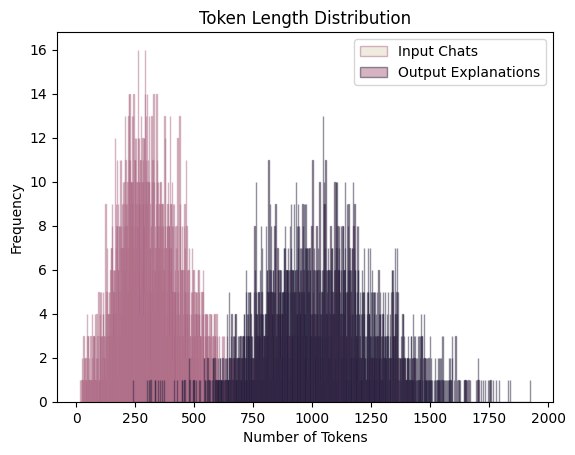

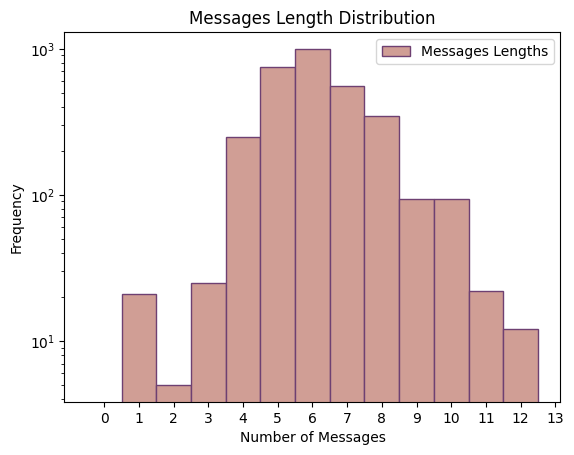

In [12]:
input_ds_token_lengths.hist(
    bins=input_ds_token_lengths.max(),
    color=colors[0],
    edgecolor=colors[2], 
    alpha=0.5, 
    label='Input Chats'
)
labels_ds_token_lengths.hist(
    bins=labels_ds_token_lengths.max(),
    color=colors[2],
    edgecolor=colors[4],
    alpha=0.5,
    label='Output Explanations'
)
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
# plt.savefig(os.path.join(OUT_DIR, "token_and_message_length_distribution.png"))
plt.grid(False)
plt.show()

# min_msgs = df['msgs_lengths'].min()
max_msgs = df['msgs_lengths'].max()
df['msgs_lengths'].hist(
    bins=range(max_msgs + 1),  # +2 so last bin includes max
    color=colors[1],
    edgecolor=colors[3],
    label='Messages Lengths',
    align='left'
)
plt.xlabel('Number of Messages')
plt.ylabel('Frequency')
plt.title('Messages Length Distribution')
plt.legend()
# plt.savefig(os.path.join(OUT_DIR, "messages_length_distribution.png"))
plt.yscale('log')
plt.xticks(range(max_msgs + 1))
plt.grid(False)
plt.show()

# Remove all samples with more than 1024 tokens in input_ids and labels
df = df[~more_than_1024_input_mask & ~more_than_1024_labels_mask]

# 📂 Dataset Splitting

In [ ]:
print(f"Users in dataset: {df['user_ids'].nunique()}")
print(f"Dataset size: {len(df)}\n")

df.drop(columns=['msgs_lengths'], inplace=True)

# Split the dataset into train, test, and eval sets using user_ids grouped examples
grouped = df.groupby('user_ids')#.size().reset_index(name='counts')
user_ids = list(grouped.groups.keys())#[:10]
# df = df[df['user_ids'].isin(user_ids)]

train_ids, test_ids = train_test_split(user_ids, test_size=TEST_SIZE, random_state=42)
train_ids, eval_ids = train_test_split(train_ids, test_size=TEST_SIZE, random_state=42)
tokenized_train_set = df[df['user_ids'].isin(train_ids)]
tokenized_test_set = df[df['user_ids'].isin(test_ids)]
tokenized_eval_set = df[df['user_ids'].isin(eval_ids)]

# Prints how many users are in each set
print(f"Users in train set: {tokenized_train_set['user_ids'].nunique()}")
print(f"Users in test set: {tokenized_test_set['user_ids'].nunique()}")
print(f"Users in eval set: {tokenized_eval_set['user_ids'].nunique()}\n")

# Remove the 'user_ids' column from the train, test, and eval sets
tokenized_train_set = tokenized_train_set.drop(columns=['user_ids'])
tokenized_test_set = tokenized_test_set.drop(columns=['user_ids'])
tokenized_eval_set = tokenized_eval_set.drop(columns=['user_ids'])

tokenized_train_set = tokenized_train_set.reset_index(drop=True)
tokenized_test_set = tokenized_test_set.reset_index(drop=True)
tokenized_eval_set = tokenized_eval_set.reset_index(drop=True)

tokenized_train_set = Dataset.from_pandas(tokenized_train_set)
tokenized_test_set = Dataset.from_pandas(tokenized_test_set)
tokenized_eval_set = Dataset.from_pandas(tokenized_eval_set)

print(f"Train set size: {len(tokenized_train_set)}")
print(f"Test set size: {len(tokenized_test_set)}")
print(f"Eval set size: {len(tokenized_eval_set)}\n")

# Set the format to PyTorch tensors
tokenized_train_set.set_format("torch")
tokenized_test_set.set_format("torch")
tokenized_eval_set.set_format("torch")

print_dataset_info(tokenized_train_set)

# 🤖 Fine-Tuning BART

In [ ]:
class TrainingEvaluationFunction():

    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.bertscore_metric = ev.load('bertscore')
    
    def __call__(self, eval_pred):
        predictions, labels = eval_pred
        # Replace -100 with pad_token_id for decoding
        labels = torch.where(
            torch.tensor(labels) == -100,
            torch.tensor(self.tokenizer.pad_token_id),
            torch.tensor(labels)
        )
        
        predicted_explanations = self.tokenizer.batch_decode(
            predictions, 
            skip_special_tokens=True
        )
        true_explanations = self.tokenizer.batch_decode(
            labels, 
            skip_special_tokens=True
        )
        
        bertscore_results = self.bertscore_metric.compute(
            predictions=predicted_explanations,
            references=true_explanations,
            lang="it",
        )
        
        bertscore_precision = sum(bertscore_results['precision']) / len(bertscore_results['precision'])
        bertscore_recall = sum(bertscore_results['recall']) / len(bertscore_results['recall'])
        bertscore_f1 = sum(bertscore_results['f1']) / len(bertscore_results['f1'])
        
        return {
            'bertscore_precision': bertscore_precision,
            'bertscore_recall': bertscore_recall,
            'bertscore_f1': bertscore_f1
        }

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    DEFAULT_CHECKPOINT
)

gen_config = GenerationConfig(
    max_length=1024,
    do_sample=True,
    top_p=0.95,
    top_k=25,
    temperature=0.6,
    decoder_start_token_id=model.config.decoder_start_token_id,
    bos_token_id=model.config.bos_token_id,
)

training_args = Seq2SeqTrainingArguments(
    output_dir=OUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,

    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=BODY_LR,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_PERCENTAGE,

    # lr_scheduler_type="linear",
    lr_scheduler_type="reduce_lr_on_plateau",
    lr_scheduler_kwargs=LR_SCHEDULER_KWARGS,

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=SAVE_TOTAL_LIMIT,
    report_to="none",

    metric_for_best_model="bertscore_f1",
    greater_is_better=True,
    predict_with_generate=True,
    generation_config=gen_config,

    fp16=torch.cuda.is_available(),
    dataloader_num_workers=NUM_WORKERS,
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    # model=model
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_eval_set,
    # tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=TrainingEvaluationFunction(tokenizer),
    callbacks=[EarlyStoppingCallback(
        early_stopping_patience=EARLY_STOPPING_PATIENCE,
        early_stopping_threshold=EARLY_STOPPING_THRESHOLD
    )]
)

train_result = trainer.train()
log_history = trainer.state.log_history
plot_losses(log_history, RESULTS_PATH)

# 📈​ Testing BART

In [ ]:
class TestingEvaluationFunction:

    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.rouge_metric = ev.load('rouge')
        self.bleu_metric = ev.load('bleu')
        self.bertscore_metric = ev.load('bertscore')

    def __call__(self, eval_pred):
        predictions, labels = eval_pred
        
        # Replace -100 with pad_token_id for decoding
        labels = torch.where(
            torch.tensor(labels) == -100,
            torch.tensor(self.tokenizer.pad_token_id),
            torch.tensor(labels)
        )
        
        predicted_explanations = self.tokenizer.batch_decode(
            predictions, 
            skip_special_tokens=True
        )
        true_explanations = self.tokenizer.batch_decode(
            labels, 
            skip_special_tokens=True
        )
        
        # Compute ROUGE scores
        rouge_results = self.rouge_metric.compute(
            predictions=predicted_explanations,
            references=true_explanations
        )
        
        # Compute BLEU score
        bleu_results = self.bleu_metric.compute(
            predictions=predicted_explanations,
            references=[[ref] for ref in true_explanations]
        )
        
        # Compute BERTScore
        bertscore_results = self.bertscore_metric.compute(
            predictions=predicted_explanations,
            references=true_explanations,
            lang="it",
        )

        bertscore_precision = sum(bertscore_results['precision']) / len(bertscore_results['precision'])
        bertscore_recall = sum(bertscore_results['recall']) / len(bertscore_results['recall'])
        bertscore_f1 = sum(bertscore_results['f1']) / len(bertscore_results['f1'])
        
        return {
            'rouge1': rouge_results['rouge1'],
            'rouge2': rouge_results['rouge2'],
            'rougeL': rouge_results['rougeL'],
            'bleu': bleu_results['bleu'],
            'bert_score_precision': bertscore_precision,
            'bert_score_recall': bertscore_recall,
            'bertscore_f1': bertscore_f1
        }


## Evaluation

In [ ]:
trainer.compute_metrics = TestingEvaluationFunction(
    tokenizer=tokenizer,
)
test_metrics = trainer.evaluate(
    eval_dataset=tokenized_test_set,
    metric_key_prefix="test",
    # tokenizer=tokenizer,
    # data_collator=data_collator
)
for key, value in test_metrics.items():
    print(f"{key}: {value}")
with open(os.path.join(RESULTS_PATH, "test_metrics.txt"), "w") as f:
    for key, value in test_metrics.items():
        f.write(f"{key}: {value}\n")

In [ ]:
if os.path.exists("/kaggle"):
    shutil.make_archive(OUT_DIR, 'zip', OUT_DIR)
    shutil.rmtree(OUT_DIR)